# 06_data_descriptive_stats

Here we load the example datasets and extract some useful statistics to describe the data.

The dataset is [CRCNS pfc-3](https://crcns.org/data-sets/pfc/pfc-3/about-pfc-2). I downloaded it and put it into a sibling directory of the grill-srnn-pfc repository folder.

## Load Data

In [ ]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


datapath = Path('.') / '..' / '..' / 'crcns_pfc-3'

The data are described in the docs that accompany the dataset. Among the datafiles is the SummaryDatabase.xlsx, which lists each neuron recorded for each experimental condition, separated for pre- and post-training, and for the spatial task only, during training.

In [ ]:
# feat_df = pd.read_excel(datapath / 'FeatureSpatialClass.xlsx')
# summ_df = pd.read_excel(datapath / 'SummaryDatabase.xlsx')

Each neuron has its own mat file. The mat file name is of the following format: `{MON}{DSET}_{STIM}_{NEUR_ID}.mat`. Where {MON} is the monkey name, {DSET} is the dataset number, {STIM} is the stimulus set (aka task, Spatial==1), and {NEUR_ID} is the neuron identified from spike soring. I'm not sure, but I think files that start with the same first 8 characters (monkey, dataset, and stim) were recorded simultaneously.

In [ ]:
from scipy.io import loadmat

from neo.core import SpikeTrain
import quantities as pq


def load_pfc3_data(path, sheet_name='Post_SpatialSet', neo_t_stop=None, verbose=0):
    """
    valid sheet_name values : 'Pre_SpatialSet', 'Post_SpatialSet', 'SPtrain_SpatialSet',
        'Pre_FeatureSets', 'Post_FeatureSets'
    """

    field_types = {
        'Cue_onT': float, 'Sample_onT': float, 'Target_onT': float,
        'trialnum': int, 'TS': list, 'IsMatch': bool
    }
    cue_locs = [[1, 0], [1, 1], [0, 1], [-1, 1], [-1, 0], [-1, -1], [0, -1], [1, -1], [0, 0]]

    path = path.resolve()
    summ_df = pd.read_excel(path / 'SummaryDatabase.xlsx', sheet_name=sheet_name)

    # Prepare output
    output = {k: [] if ty == list else np.array([], dtype=ty) for k, ty in field_types.items()}
    output['sess_name'] = np.array([], dtype=object)
    output['area'] = np.array([], dtype=object)
    output['neur_id'] = np.array([], dtype=int)
    output['class_ix'] = np.array([], dtype=int)

    # Parse all data files
    # Iterate through all unique sessions
    uq_sess = summ_df['Filename'].unique()
    for sess_ix, sess_name in enumerate(uq_sess):
        # Iterate through each neuron-file in each session
        b_sess = summ_df['Filename'] == sess_name
        neur_ids = summ_df[b_sess]['Neuron']
        areas = summ_df[b_sess]['Area']
        for n_ix, neur_id in enumerate(neur_ids):
            area = areas.values[n_ix]
            # Load each neuron-file.
            mat_path = path / 'data' / (sess_name.upper() + '_' + str(neur_id) + '.mat')
            if not mat_path.exists():
                mat_path = datapath.resolve() / 'data' / (sess_name.lower() + '_' + str(neur_id) + '.mat')
            if verbose > 0:
                print(f"Loading session and neuron {mat_path}...")
            mat_data = loadmat(mat_path, squeeze_me=False)['MatData'][0, 0]
            ntr = mat_data['class']['ntr'][0]

            # Iterate through 'classes' (aka task conditions)
            for class_ix, cue_loc in enumerate(cue_locs):
                class_trials = ntr[class_ix][0]
                n_trials = len(class_trials['trialnum'])
                output['sess_name'] = np.append(output['sess_name'], [sess_name] * n_trials)
                output['area'] = np.append(output['area'], [area] * n_trials)
                output['neur_id'] = np.append(output['neur_id'], [neur_id] * n_trials)
                output['class_ix'] = np.append(output['class_ix'], [class_ix] * n_trials)
                for k, ty in field_types.items():
                    if ty != list:
                        output[k] = np.append(output[k],
                                              np.array([_.squeeze()[()] for _ in class_trials[k]],
                                                       dtype=ty)
                                             )
                    else:
                        
                        if neo_t_stop is not None:
                            # https://neo.readthedocs.io/en/stable/api_reference.html#neo.core.SpikeTrain
                            spike_times = [SpikeTrain(_.flatten()[_.flatten() <= neo_t_stop],
                                                      units=pq.s, t_stop=neo_t_stop)
                                           for _ in class_trials[k]]
                        else:
                            spike_times = [_.flatten().tolist() for _ in class_trials[k]]
                        output[k].extend(spike_times)


        output['Cue_X'] = np.array([cue_locs[_][0] for _ in output['class_ix']], dtype=float)
        output['Cue_Y'] = np.array([cue_locs[_][1] for _ in output['class_ix']], dtype=float)
    if sheet_name.endswith('SpatialSet'):
        output['Sample_X'] = np.copy(output['Cue_X'])
        output['Sample_Y'] = np.copy(output['Cue_Y'])
        # Fix non-match
        output['Sample_X'][~output['IsMatch']] = -1 * output['Cue_X'][~output['IsMatch']]
        output['Sample_Y'][~output['IsMatch']] = -1 * output['Cue_Y'][~output['IsMatch']]
        # Fix trials with center cue: I'm not certain about this. Docs ambiguous. We should drop center cue trials.
        b_center = output['class_ix'] == 8
        output['Sample_X'][b_center] = 1 - 2 * output['IsMatch'][b_center].astype(int)
    else:
        # TODO: Fix sample locations for FeatureSets
        # TODO: Add 
        pass

    df = pd.DataFrame.from_dict(output, orient='index').transpose().infer_objects()

    if verbose > 0:
        n_neurons = len(df[['sess_name', 'neur_id']].drop_duplicates())
        n_sess = len(df['sess_name'].unique())
        print(f"Found {n_neurons} neurons in {n_sess} sessions ({n_neurons/n_sess:.2f} neur/sess).")

    return df

In [ ]:
df = load_pfc3_data(datapath, neo_t_stop=6.0, verbose=1)

Loading session and neuron /media/chad/STORE/Tools/Neurophys/Telluride2020/crcns_pfc-3/data/ELV088_1_2001.mat...
Loading session and neuron /media/chad/STORE/Tools/Neurophys/Telluride2020/crcns_pfc-3/data/ELV088_1_2002.mat...
Loading session and neuron /media/chad/STORE/Tools/Neurophys/Telluride2020/crcns_pfc-3/data/ELV088_1_2003.mat...
Loading session and neuron /media/chad/STORE/Tools/Neurophys/Telluride2020/crcns_pfc-3/data/ELV089_1_2004.mat...
Loading session and neuron /media/chad/STORE/Tools/Neurophys/Telluride2020/crcns_pfc-3/data/ELV089_1_2006.mat...
Loading session and neuron /media/chad/STORE/Tools/Neurophys/Telluride2020/crcns_pfc-3/data/ELV090_1_2007.mat...
Loading session and neuron /media/chad/STORE/Tools/Neurophys/Telluride2020/crcns_pfc-3/data/ELV090_1_2008.mat...
Loading session and neuron /media/chad/STORE/Tools/Neurophys/Telluride2020/crcns_pfc-3/data/ELV091_1_2011.mat...
Loading session and neuron /media/chad/STORE/Tools/Neurophys/Telluride2020/crcns_pfc-3/data/ELV0

Loading session and neuron /media/chad/STORE/Tools/Neurophys/Telluride2020/crcns_pfc-3/data/ELV119_1_2168.mat...
Loading session and neuron /media/chad/STORE/Tools/Neurophys/Telluride2020/crcns_pfc-3/data/ELV119_1_2169.mat...
Loading session and neuron /media/chad/STORE/Tools/Neurophys/Telluride2020/crcns_pfc-3/data/ELV119_1_2170.mat...
Loading session and neuron /media/chad/STORE/Tools/Neurophys/Telluride2020/crcns_pfc-3/data/ELV120_1_2171.mat...
Loading session and neuron /media/chad/STORE/Tools/Neurophys/Telluride2020/crcns_pfc-3/data/ELV120_1_2172.mat...
Loading session and neuron /media/chad/STORE/Tools/Neurophys/Telluride2020/crcns_pfc-3/data/ELV120_1_2173.mat...
Loading session and neuron /media/chad/STORE/Tools/Neurophys/Telluride2020/crcns_pfc-3/data/ELV120_1_2174.mat...
Loading session and neuron /media/chad/STORE/Tools/Neurophys/Telluride2020/crcns_pfc-3/data/ELV120_1_2175.mat...
Loading session and neuron /media/chad/STORE/Tools/Neurophys/Telluride2020/crcns_pfc-3/data/ELV1

Loading session and neuron /media/chad/STORE/Tools/Neurophys/Telluride2020/crcns_pfc-3/data/ELV148_1_2388.mat...
Loading session and neuron /media/chad/STORE/Tools/Neurophys/Telluride2020/crcns_pfc-3/data/ELV148_1_2389.mat...
Loading session and neuron /media/chad/STORE/Tools/Neurophys/Telluride2020/crcns_pfc-3/data/ELV148_1_2390.mat...
Loading session and neuron /media/chad/STORE/Tools/Neurophys/Telluride2020/crcns_pfc-3/data/elv177_1_2552.mat...
Loading session and neuron /media/chad/STORE/Tools/Neurophys/Telluride2020/crcns_pfc-3/data/elv177_1_2553.mat...
Loading session and neuron /media/chad/STORE/Tools/Neurophys/Telluride2020/crcns_pfc-3/data/elv177_1_2554.mat...
Loading session and neuron /media/chad/STORE/Tools/Neurophys/Telluride2020/crcns_pfc-3/data/elv177_1_2555.mat...
Loading session and neuron /media/chad/STORE/Tools/Neurophys/Telluride2020/crcns_pfc-3/data/elv177_1_2556.mat...
Loading session and neuron /media/chad/STORE/Tools/Neurophys/Telluride2020/crcns_pfc-3/data/elv1

Loading session and neuron /media/chad/STORE/Tools/Neurophys/Telluride2020/crcns_pfc-3/data/ELV189_1_5046.mat...
Loading session and neuron /media/chad/STORE/Tools/Neurophys/Telluride2020/crcns_pfc-3/data/ELV189_1_5049.mat...
Loading session and neuron /media/chad/STORE/Tools/Neurophys/Telluride2020/crcns_pfc-3/data/ELV189_1_5050.mat...
Loading session and neuron /media/chad/STORE/Tools/Neurophys/Telluride2020/crcns_pfc-3/data/ELV189_1_5051.mat...
Loading session and neuron /media/chad/STORE/Tools/Neurophys/Telluride2020/crcns_pfc-3/data/ELV189_1_5052.mat...
Loading session and neuron /media/chad/STORE/Tools/Neurophys/Telluride2020/crcns_pfc-3/data/ELV189_1_5053.mat...
Loading session and neuron /media/chad/STORE/Tools/Neurophys/Telluride2020/crcns_pfc-3/data/ELV191_1_5067.mat...
Loading session and neuron /media/chad/STORE/Tools/Neurophys/Telluride2020/crcns_pfc-3/data/ELV191_1_5068.mat...
Loading session and neuron /media/chad/STORE/Tools/Neurophys/Telluride2020/crcns_pfc-3/data/ELV1

Loading session and neuron /media/chad/STORE/Tools/Neurophys/Telluride2020/crcns_pfc-3/data/ELV198_1_5149.mat...
Loading session and neuron /media/chad/STORE/Tools/Neurophys/Telluride2020/crcns_pfc-3/data/ELV198_1_5152.mat...
Loading session and neuron /media/chad/STORE/Tools/Neurophys/Telluride2020/crcns_pfc-3/data/ELV198_1_5153.mat...
Loading session and neuron /media/chad/STORE/Tools/Neurophys/Telluride2020/crcns_pfc-3/data/ELV198_1_5154.mat...
Loading session and neuron /media/chad/STORE/Tools/Neurophys/Telluride2020/crcns_pfc-3/data/ELV198_1_5155.mat...
Loading session and neuron /media/chad/STORE/Tools/Neurophys/Telluride2020/crcns_pfc-3/data/ELV198_1_5156.mat...
Loading session and neuron /media/chad/STORE/Tools/Neurophys/Telluride2020/crcns_pfc-3/data/ELV198_1_5157.mat...
Loading session and neuron /media/chad/STORE/Tools/Neurophys/Telluride2020/crcns_pfc-3/data/ELV199_1_5158.mat...
Loading session and neuron /media/chad/STORE/Tools/Neurophys/Telluride2020/crcns_pfc-3/data/ELV1

Loading session and neuron /media/chad/STORE/Tools/Neurophys/Telluride2020/crcns_pfc-3/data/ELV214_1_5333.mat...
Loading session and neuron /media/chad/STORE/Tools/Neurophys/Telluride2020/crcns_pfc-3/data/ELV214_1_5334.mat...
Loading session and neuron /media/chad/STORE/Tools/Neurophys/Telluride2020/crcns_pfc-3/data/ELV214_1_5335.mat...
Loading session and neuron /media/chad/STORE/Tools/Neurophys/Telluride2020/crcns_pfc-3/data/ELV214_1_5336.mat...
Loading session and neuron /media/chad/STORE/Tools/Neurophys/Telluride2020/crcns_pfc-3/data/ELV215_1_5342.mat...
Loading session and neuron /media/chad/STORE/Tools/Neurophys/Telluride2020/crcns_pfc-3/data/ELV215_1_5343.mat...
Loading session and neuron /media/chad/STORE/Tools/Neurophys/Telluride2020/crcns_pfc-3/data/ELV215_1_5344.mat...
Loading session and neuron /media/chad/STORE/Tools/Neurophys/Telluride2020/crcns_pfc-3/data/ELV215_1_5345.mat...
Loading session and neuron /media/chad/STORE/Tools/Neurophys/Telluride2020/crcns_pfc-3/data/ELV2

Loading session and neuron /media/chad/STORE/Tools/Neurophys/Telluride2020/crcns_pfc-3/data/ELV230_1_5479.mat...
Loading session and neuron /media/chad/STORE/Tools/Neurophys/Telluride2020/crcns_pfc-3/data/ELV231_1_5481.mat...
Loading session and neuron /media/chad/STORE/Tools/Neurophys/Telluride2020/crcns_pfc-3/data/ELV231_1_5482.mat...
Loading session and neuron /media/chad/STORE/Tools/Neurophys/Telluride2020/crcns_pfc-3/data/ELV232_1_5483.mat...
Loading session and neuron /media/chad/STORE/Tools/Neurophys/Telluride2020/crcns_pfc-3/data/ELV232_1_5484.mat...
Loading session and neuron /media/chad/STORE/Tools/Neurophys/Telluride2020/crcns_pfc-3/data/ELV232_1_5485.mat...
Loading session and neuron /media/chad/STORE/Tools/Neurophys/Telluride2020/crcns_pfc-3/data/ELV232_1_5486.mat...
Loading session and neuron /media/chad/STORE/Tools/Neurophys/Telluride2020/crcns_pfc-3/data/ELV232_1_5489.mat...
Loading session and neuron /media/chad/STORE/Tools/Neurophys/Telluride2020/crcns_pfc-3/data/ELV2

/home/chad/miniconda3/envs/srnn_pfc/lib/python3.7/site-packages/ipykernel_launcher.py:60: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


Loading session and neuron /media/chad/STORE/Tools/Neurophys/Telluride2020/crcns_pfc-3/data/ADR030_2_6000.mat...
Loading session and neuron /media/chad/STORE/Tools/Neurophys/Telluride2020/crcns_pfc-3/data/ADR030_2_6001.mat...
Loading session and neuron /media/chad/STORE/Tools/Neurophys/Telluride2020/crcns_pfc-3/data/ADR030_2_6003.mat...
Loading session and neuron /media/chad/STORE/Tools/Neurophys/Telluride2020/crcns_pfc-3/data/ADR030_2_6004.mat...
Loading session and neuron /media/chad/STORE/Tools/Neurophys/Telluride2020/crcns_pfc-3/data/ADR030_2_6005.mat...
Loading session and neuron /media/chad/STORE/Tools/Neurophys/Telluride2020/crcns_pfc-3/data/ADR030_2_6006.mat...
Loading session and neuron /media/chad/STORE/Tools/Neurophys/Telluride2020/crcns_pfc-3/data/ADR030_2_6007.mat...
Loading session and neuron /media/chad/STORE/Tools/Neurophys/Telluride2020/crcns_pfc-3/data/ADR030_2_6008.mat...
Loading session and neuron /media/chad/STORE/Tools/Neurophys/Telluride2020/crcns_pfc-3/data/ADR0

Loading session and neuron /media/chad/STORE/Tools/Neurophys/Telluride2020/crcns_pfc-3/data/ADR044_1_6115.mat...
Loading session and neuron /media/chad/STORE/Tools/Neurophys/Telluride2020/crcns_pfc-3/data/ADR044_1_6116.mat...
Loading session and neuron /media/chad/STORE/Tools/Neurophys/Telluride2020/crcns_pfc-3/data/ADR044_1_6117.mat...
Loading session and neuron /media/chad/STORE/Tools/Neurophys/Telluride2020/crcns_pfc-3/data/ADR044_1_6118.mat...
Loading session and neuron /media/chad/STORE/Tools/Neurophys/Telluride2020/crcns_pfc-3/data/ADR045_1_6119.mat...
Loading session and neuron /media/chad/STORE/Tools/Neurophys/Telluride2020/crcns_pfc-3/data/ADR045_1_6120.mat...
Loading session and neuron /media/chad/STORE/Tools/Neurophys/Telluride2020/crcns_pfc-3/data/ADR045_1_6121.mat...
Loading session and neuron /media/chad/STORE/Tools/Neurophys/Telluride2020/crcns_pfc-3/data/ADR045_1_6122.mat...
Loading session and neuron /media/chad/STORE/Tools/Neurophys/Telluride2020/crcns_pfc-3/data/ADR0

Loading session and neuron /media/chad/STORE/Tools/Neurophys/Telluride2020/crcns_pfc-3/data/ELV104_1_2070.mat...
Loading session and neuron /media/chad/STORE/Tools/Neurophys/Telluride2020/crcns_pfc-3/data/ELV104_1_2071.mat...
Loading session and neuron /media/chad/STORE/Tools/Neurophys/Telluride2020/crcns_pfc-3/data/ELV104_1_2078.mat...
Loading session and neuron /media/chad/STORE/Tools/Neurophys/Telluride2020/crcns_pfc-3/data/ELV104_1_2079.mat...
Loading session and neuron /media/chad/STORE/Tools/Neurophys/Telluride2020/crcns_pfc-3/data/ELV105_1_2080.mat...
Loading session and neuron /media/chad/STORE/Tools/Neurophys/Telluride2020/crcns_pfc-3/data/ELV105_1_2081.mat...
Loading session and neuron /media/chad/STORE/Tools/Neurophys/Telluride2020/crcns_pfc-3/data/ELV105_1_2082.mat...
Loading session and neuron /media/chad/STORE/Tools/Neurophys/Telluride2020/crcns_pfc-3/data/ELV105_1_2084.mat...
Loading session and neuron /media/chad/STORE/Tools/Neurophys/Telluride2020/crcns_pfc-3/data/ELV1

Loading session and neuron /media/chad/STORE/Tools/Neurophys/Telluride2020/crcns_pfc-3/data/ELV135_1_2296.mat...
Loading session and neuron /media/chad/STORE/Tools/Neurophys/Telluride2020/crcns_pfc-3/data/ELV135_1_2297.mat...
Loading session and neuron /media/chad/STORE/Tools/Neurophys/Telluride2020/crcns_pfc-3/data/ELV135_1_2300.mat...
Loading session and neuron /media/chad/STORE/Tools/Neurophys/Telluride2020/crcns_pfc-3/data/ELV135_1_2301.mat...
Loading session and neuron /media/chad/STORE/Tools/Neurophys/Telluride2020/crcns_pfc-3/data/ELV135_1_2303.mat...
Loading session and neuron /media/chad/STORE/Tools/Neurophys/Telluride2020/crcns_pfc-3/data/ELV135_1_2305.mat...
Loading session and neuron /media/chad/STORE/Tools/Neurophys/Telluride2020/crcns_pfc-3/data/ELV135_1_2308.mat...
Loading session and neuron /media/chad/STORE/Tools/Neurophys/Telluride2020/crcns_pfc-3/data/ELV135_1_2309.mat...
Loading session and neuron /media/chad/STORE/Tools/Neurophys/Telluride2020/crcns_pfc-3/data/ELV1

Loading session and neuron /media/chad/STORE/Tools/Neurophys/Telluride2020/crcns_pfc-3/data/ELV195_1_5122.mat...
Loading session and neuron /media/chad/STORE/Tools/Neurophys/Telluride2020/crcns_pfc-3/data/ELV195_1_5123.mat...
Loading session and neuron /media/chad/STORE/Tools/Neurophys/Telluride2020/crcns_pfc-3/data/ELV195_1_5124.mat...
Loading session and neuron /media/chad/STORE/Tools/Neurophys/Telluride2020/crcns_pfc-3/data/ELV204_1_5189.mat...
Loading session and neuron /media/chad/STORE/Tools/Neurophys/Telluride2020/crcns_pfc-3/data/ELV204_1_5190.mat...
Loading session and neuron /media/chad/STORE/Tools/Neurophys/Telluride2020/crcns_pfc-3/data/ELV204_1_5191.mat...
Loading session and neuron /media/chad/STORE/Tools/Neurophys/Telluride2020/crcns_pfc-3/data/ELV205_1_5192.mat...
Loading session and neuron /media/chad/STORE/Tools/Neurophys/Telluride2020/crcns_pfc-3/data/ELV205_1_5193.mat...
Loading session and neuron /media/chad/STORE/Tools/Neurophys/Telluride2020/crcns_pfc-3/data/ELV2

Loading session and neuron /media/chad/STORE/Tools/Neurophys/Telluride2020/crcns_pfc-3/data/ELV268_1_5524.mat...
Loading session and neuron /media/chad/STORE/Tools/Neurophys/Telluride2020/crcns_pfc-3/data/ELV268_1_5525.mat...
Loading session and neuron /media/chad/STORE/Tools/Neurophys/Telluride2020/crcns_pfc-3/data/ELV268_1_5526.mat...
Loading session and neuron /media/chad/STORE/Tools/Neurophys/Telluride2020/crcns_pfc-3/data/ELV268_1_5527.mat...
Loading session and neuron /media/chad/STORE/Tools/Neurophys/Telluride2020/crcns_pfc-3/data/ELV268_1_5528.mat...
Loading session and neuron /media/chad/STORE/Tools/Neurophys/Telluride2020/crcns_pfc-3/data/ELV269_1_5529.mat...
Loading session and neuron /media/chad/STORE/Tools/Neurophys/Telluride2020/crcns_pfc-3/data/ELV269_1_5530.mat...
Loading session and neuron /media/chad/STORE/Tools/Neurophys/Telluride2020/crcns_pfc-3/data/ELV269_1_5531.mat...
Loading session and neuron /media/chad/STORE/Tools/Neurophys/Telluride2020/crcns_pfc-3/data/ELV2

Loading session and neuron /media/chad/STORE/Tools/Neurophys/Telluride2020/crcns_pfc-3/data/ELV284_1_5622.mat...
Loading session and neuron /media/chad/STORE/Tools/Neurophys/Telluride2020/crcns_pfc-3/data/ELV284_1_5623.mat...
Loading session and neuron /media/chad/STORE/Tools/Neurophys/Telluride2020/crcns_pfc-3/data/ELV284_1_5624.mat...
Loading session and neuron /media/chad/STORE/Tools/Neurophys/Telluride2020/crcns_pfc-3/data/ELV284_1_5625.mat...
Loading session and neuron /media/chad/STORE/Tools/Neurophys/Telluride2020/crcns_pfc-3/data/ELV284_1_5626.mat...
Loading session and neuron /media/chad/STORE/Tools/Neurophys/Telluride2020/crcns_pfc-3/data/ELV284_1_5627.mat...
Loading session and neuron /media/chad/STORE/Tools/Neurophys/Telluride2020/crcns_pfc-3/data/ADR031_1_6010.mat...
Loading session and neuron /media/chad/STORE/Tools/Neurophys/Telluride2020/crcns_pfc-3/data/ADR031_1_6011.mat...
Loading session and neuron /media/chad/STORE/Tools/Neurophys/Telluride2020/crcns_pfc-3/data/ADR0

Found 1007 neurons in 162 sessions (6.22 neur/sess).


There are ~ 3k rows from ~9 sessions where the sess_name suffix, indicating the stimulus type, does not end in `_1`. Either these were mis-labeled, or they are from a different experiment (e.g. feature, or joint task). We will keep only rows that end with `_1`.

In [ ]:
df = df[df['sess_name'].str.endswith('_1')]

Here we print out a few rows sharing the same trial number and session name, but different neur_id. We can examine which columns are available, and verify these neurons are indeed recorded simultaneously (note the identical event timestamps).

In [ ]:
_ = np.where(np.logical_and(df['trialnum'] == 27, df['sess_name'] == 'ELV088_1'))[0]
df.iloc[_]

,Cue_onT,Sample_onT,Target_onT,trialnum,TS,IsMatch,sess_name,area,neur_id,class_ix,Cue_X,Cue_Y,Sample_X,Sample_Y
2,1.0693,3.1035,5.137725,27,"[0.073325 s, 5.3705 s]",True,ELV088_1,dorsal,2001,0,1.0,0.0,1.0,0.0
182,1.0693,3.1035,5.137725,27,"[5.347875 s, 5.685575 s]",True,ELV088_1,dorsal,2002,0,1.0,0.0,1.0,0.0
362,1.0693,3.1035,5.137725,27,[5.304125 s],True,ELV088_1,dorsal,2003,0,1.0,0.0,1.0,0.0


## Describe Neurons

First get some general information about our data: 

In [ ]:
n_neurons = len(df[['sess_name', 'neur_id']].drop_duplicates())
n_sess = len(df['sess_name'].unique())
print(f"Found {n_neurons} neurons in {n_sess} sessions ({n_neurons/n_sess:.2f} neur/sess), ")
print(f"with the following class_ix values: {df['class_ix'].unique()}")

Found 984 neurons in 159 sessions (6.19 neur/sess), 
with the following class_ix values: [0 1 2 3 4 5 6 7 8]


### Summary Statistics

Collect information for each neuron. We want to build an ISI histogram, CV, and firing rate for each neuron. We also want to look at the tuning curves for a few well-tuned neurons.

Periods are defined as follows:

| Period   | Start            | Stop             |
| ------   | -----            | ----             |
| Baseline | 0                | Cue_onT          |
| Cue      | Cue_onT          | Cue_onT + 0.5    |
| Delay1   | Cue_onT + 0.5    | Cue_onT + 2.0    |
| Sample   | Sample_onT       | Sample_onT + 0.5 |
| Delay2   | Sample_onT + 0.5 | Sample_onT + 2.0 |
| Total    | 0                | 6.0              |


In [ ]:
periods = [
    {'name': 'baseline', 'start_ev': None, 'start_offset': 0, 'stop_ev': 'Cue_onT', 'stop_offset': 0.0},
    {'name': 'cue', 'start_ev': 'Cue_onT', 'start_offset': 0, 'stop_ev': 'Cue_onT', 'stop_offset': 0.5},
    {'name': 'delay1', 'start_ev': 'Cue_onT', 'start_offset': 0.5, 'stop_ev': 'Cue_onT', 'stop_offset': 2.0},
    {'name': 'sample', 'start_ev': 'Sample_onT', 'start_offset': 0, 'stop_ev': 'Sample_onT', 'stop_offset': 0.5},
    {'name': 'delay2', 'start_ev': 'Sample_onT', 'start_offset': 0.5, 'stop_ev': 'Sample_onT', 'stop_offset': 2.0},
    {'name': 'total', 'start_ev': None, 'start_offset': 0, 'stop_ev': None, 'stop_offset': 6.0},
]

Run through the neurons, extracting their **coefficients of variation**, **correlation timescales**, **firing rates**, and **correlation coefficient** between spike counts in delay1 and cue location.

In [ ]:
from elephant.statistics import isi, cv
from elephant.conversion import BinnedSpikeTrain
from elephant.spike_train_correlation import spike_train_timescale
from pingouin import circ_corrcl


bin_size = 1 * pq.ms
max_tau = 500 * pq.ms


neur_ids = df['neur_id'].unique()
isi_out = []
cv_out = np.nan * np.ones((len(neur_ids), 1))
ts_out = np.nan * np.ones((len(neur_ids), 1))
rates_m_std = np.nan * np.ones((2, len(neur_ids)))
z_rates_m_sem = np.nan * np.ones((2, len(neur_ids), len(periods), 8, 2))
max_rates = np.nan * np.ones((len(neur_ids), 1))
Rsq_xy = np.nan * np.ones((len(neur_ids), len(periods), 4))


for n_ix, n_id in enumerate(neur_ids):
    if n_ix > 0 and n_ix % 10 == 0:
        print(f"Processing neuron {n_id} ({n_ix + 1} / {len(neur_ids)})...")
    df_n = df[df['neur_id'] == n_id]
    all_spiketimes = df_n['TS'].values.tolist()
    all_isis = [isi(_) for _ in all_spiketimes]
    all_isis = np.concatenate(all_isis) * pq.s
    
    isi_out.append(all_isis)
    if len(all_isis) > 0:
        cv_out[n_ix] = cv(all_isis)
        
    # Calculate autocorrelation timescale
    flat_spiketimes = np.array([])
    for row_ix, st in enumerate(all_spiketimes):
        flat_spiketimes = np.concatenate((flat_spiketimes, row_ix * 6.0 + st.magnitude))
    t_stop = (np.max(flat_spiketimes) + 1e-3) * pq.s
    flat_spiketrain = SpikeTrain(flat_spiketimes, units=pq.s, t_stop=t_stop)
    if flat_spiketrain.size > 1:
        binned_spiketrain = BinnedSpikeTrain(flat_spiketrain, bin_size=bin_size, t_stop=t_stop, tolerance=None)
        ts_out[n_ix] = spike_train_timescale(binned_spiketrain, max_tau).rescale(pq.s).magnitude
       
    # Get total rate and std for this neuron - needed for z-scoring
    all_rates = np.array([len(_) for _ in all_spiketimes]) / 6.0
    rates_m_std[0, n_ix], rates_m_std[1, n_ix] = np.mean(all_rates), np.std(all_rates)
    
    for p_ix, per in enumerate(periods):
        t_start = per['start_offset'] + (df_n[per['start_ev']].values if per['start_ev'] is not None
                                         else np.zeros((len(df_n),)))
        t_stop = per['stop_offset'] + (df_n[per['stop_ev']].values if per['stop_ev'] is not None
                                       else np.zeros((len(df_n),)))
        per_spiketimes = [_[np.logical_and(t_start[ix] <= _, _ < t_stop[ix])]
                         for ix, _ in enumerate(all_spiketimes)]
        counts = np.array([len(_) for _ in per_spiketimes])
        rates = counts / (t_stop - t_start)
        z_rates = (rates - rates_m_std[0, n_ix]) / (rates_m_std[1, n_ix] + 1e-9)
        
        if np.any(counts > 0):
            # / np.sqrt(2) so diagonals have radius == 1
            x, y = df_n['Cue_X'].values / np.sqrt(2), df_n['Cue_Y'].values / np.sqrt(2)
            
            for dv_ix, dv in enumerate([x, y, np.stack((x, y), axis=1)]):

                # Regress z_rates vs x,y (multivariate)
                coef_, ss_res, rank, sing_val = np.linalg.lstsq(np.stack((np.ones_like(x), x, y), axis=1),
                                                                z_rates, rcond=None)
                ss_tot = np.sum((z_rates - np.mean(z_rates))**2)
                Rsq_xy[n_ix, p_ix, dv_ix] = 1 - (ss_res[0] / ss_tot)

            # Regress z_rates vs angle (circular regression)
            # rho = np.sqrt(x**2 + y**2)
            phi = np.arctan2(y, x) % (2*np.pi)
            Rsq_xy[n_ix, p_ix, -1] = circ_corrcl(phi, z_rates)[0]
        
        # Iterate over trial conditions
        for c_ix in range(8):
            b_class = df_n['class_ix'].values == c_ix
            # df_nc = df_n[df_n['class_ix'] == c_ix]

            for m_ix, m_val in enumerate([True, False]):
                b_match = df_n['IsMatch'].values == m_val
                if np.any(b_class & b_match):
                    max_rates[n_ix] = np.nanmax((max_rates[n_ix, 0], np.nanmax(rates[b_class & b_match])))
                    this_rates = z_rates[b_class & b_match]
                    z_rates_m_sem[0, n_ix, p_ix, c_ix, m_ix] = np.mean(this_rates)
                    z_rates_m_sem[1, n_ix, p_ix, c_ix, m_ix] = np.std(this_rates) / np.sqrt(len(this_rates))
            

Processing neuron 2015 (11 / 984)...
Processing neuron 2026 (21 / 984)...
Processing neuron 2045 (31 / 984)...
Processing neuron 2106 (41 / 984)...
Processing neuron 2138 (51 / 984)...
Processing neuron 2149 (61 / 984)...
Processing neuron 2175 (71 / 984)...
Processing neuron 2191 (81 / 984)...
Processing neuron 2210 (91 / 984)...
Processing neuron 2232 (101 / 984)...
Processing neuron 2278 (111 / 984)...
Processing neuron 2360 (121 / 984)...
Processing neuron 2371 (131 / 984)...
Processing neuron 2555 (141 / 984)...
Processing neuron 2566 (151 / 984)...
Processing neuron 2576 (161 / 984)...
Processing neuron 2586 (171 / 984)...
Processing neuron 2604 (181 / 984)...


/home/chad/miniconda3/envs/srnn_pfc/lib/python3.7/site-packages/elephant/conversion.py:495: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))


Processing neuron 5025 (191 / 984)...
Processing neuron 5035 (201 / 984)...
Processing neuron 5045 (211 / 984)...
Processing neuron 5070 (221 / 984)...
Processing neuron 5080 (231 / 984)...
Processing neuron 5090 (241 / 984)...


/home/chad/miniconda3/envs/srnn_pfc/lib/python3.7/site-packages/elephant/conversion.py:495: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))


Processing neuron 5101 (251 / 984)...
Processing neuron 5115 (261 / 984)...


/home/chad/miniconda3/envs/srnn_pfc/lib/python3.7/site-packages/elephant/conversion.py:495: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))


Processing neuron 5129 (271 / 984)...
Processing neuron 5139 (281 / 984)...
Processing neuron 5149 (291 / 984)...
Processing neuron 5161 (301 / 984)...
Processing neuron 5171 (311 / 984)...


/home/chad/miniconda3/envs/srnn_pfc/lib/python3.7/site-packages/elephant/conversion.py:495: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))


Processing neuron 5182 (321 / 984)...
Processing neuron 5280 (331 / 984)...


/home/chad/miniconda3/envs/srnn_pfc/lib/python3.7/site-packages/elephant/conversion.py:495: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))


Processing neuron 5290 (341 / 984)...
Processing neuron 5318 (351 / 984)...
Processing neuron 5328 (361 / 984)...
Processing neuron 5343 (371 / 984)...
Processing neuron 5349 (381 / 984)...
Processing neuron 5359 (391 / 984)...
Processing neuron 5369 (401 / 984)...


/home/chad/miniconda3/envs/srnn_pfc/lib/python3.7/site-packages/elephant/conversion.py:495: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))


Processing neuron 5388 (411 / 984)...
Processing neuron 5399 (421 / 984)...
Processing neuron 5441 (431 / 984)...
Processing neuron 5477 (441 / 984)...
Processing neuron 5490 (451 / 984)...
Processing neuron 5500 (461 / 984)...
Processing neuron 6000 (471 / 984)...
Processing neuron 6027 (481 / 984)...
Processing neuron 6037 (491 / 984)...
Processing neuron 6047 (501 / 984)...
Processing neuron 6061 (511 / 984)...
Processing neuron 6074 (521 / 984)...
Processing neuron 6098 (531 / 984)...
Processing neuron 6112 (541 / 984)...
Processing neuron 6122 (551 / 984)...
Processing neuron 6137 (561 / 984)...
Processing neuron 6166 (571 / 984)...
Processing neuron 6190 (581 / 984)...
Processing neuron 6222 (591 / 984)...
Processing neuron 2059 (601 / 984)...
Processing neuron 2078 (611 / 984)...
Processing neuron 2093 (621 / 984)...
Processing neuron 2118 (631 / 984)...


/home/chad/miniconda3/envs/srnn_pfc/lib/python3.7/site-packages/elephant/conversion.py:495: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))


Processing neuron 2153 (641 / 984)...
Processing neuron 2164 (651 / 984)...
Processing neuron 2197 (661 / 984)...
Processing neuron 2224 (671 / 984)...
Processing neuron 2257 (681 / 984)...
Processing neuron 2308 (691 / 984)...
Processing neuron 2327 (701 / 984)...
Processing neuron 2340 (711 / 984)...
Processing neuron 2350 (721 / 984)...
Processing neuron 2375 (731 / 984)...
Processing neuron 5012 (741 / 984)...
Processing neuron 5062 (751 / 984)...
Processing neuron 5124 (761 / 984)...
Processing neuron 5302 (771 / 984)...
Processing neuron 5402 (781 / 984)...
Processing neuron 5415 (791 / 984)...
Processing neuron 5437 (801 / 984)...
Processing neuron 5464 (811 / 984)...
Processing neuron 5475 (821 / 984)...


/home/chad/miniconda3/envs/srnn_pfc/lib/python3.7/site-packages/elephant/conversion.py:495: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))


Processing neuron 5521 (831 / 984)...
Processing neuron 5531 (841 / 984)...
Processing neuron 5552 (851 / 984)...
Processing neuron 5563 (861 / 984)...
Processing neuron 5578 (871 / 984)...
Processing neuron 5588 (881 / 984)...
Processing neuron 5600 (891 / 984)...
Processing neuron 5612 (901 / 984)...
Processing neuron 5623 (911 / 984)...
Processing neuron 6015 (921 / 984)...
Processing neuron 6050 (931 / 984)...
Processing neuron 6093 (941 / 984)...
Processing neuron 6145 (951 / 984)...
Processing neuron 6183 (961 / 984)...
Processing neuron 6205 (971 / 984)...
Processing neuron 6231 (981 / 984)...


#### Distribution of CVs

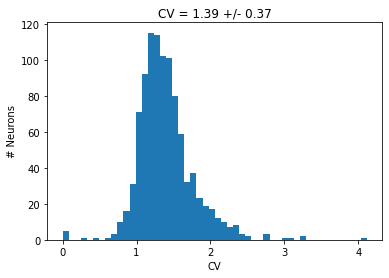

In [ ]:
plt.hist(cv_out[~np.isnan(cv_out)], bins=50)
plt.xlabel('CV')
plt.ylabel('# Neurons')
plt.title(f"CV = {np.nanmean(cv_out):.2f} +/- {np.nanstd(cv_out):.2f}")
plt.show()

#### Distribution of firing rates. (Note the log-scale in the plot.)

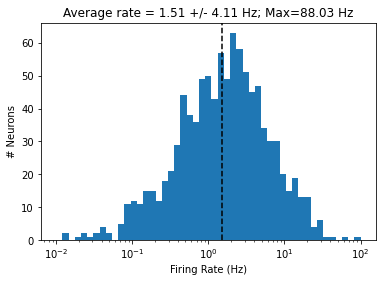

In [ ]:
avg_rate, sigma_rate = 10**np.mean(np.log10(rates_m_std[0])), 10**np.std(np.log10(rates_m_std[0]))

plt.hist(rates_m_std[0], bins=10 ** np.linspace(np.log10(0.01), np.log10(100), 50))
plt.xlabel('Firing Rate (Hz)')
plt.ylabel('# Neurons')
plt.gca().set_xscale("log")
plt.axvline(avg_rate, ls='--', color='k')
plt.title(f"Average rate = {avg_rate:.2f} +/- {sigma_rate:.2f} Hz; Max={np.max(rates_m_std[0]):.2f} Hz")
plt.show()

#### Distribution of Max Firing Rates

Used to parameterize nengo network.


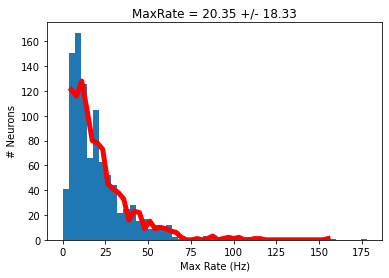

In [ ]:
import nengo.dists


counts, bins, patches = plt.hist(max_rates, bins=50)
plt.xlabel('Max Rate (Hz)')
plt.ylabel('# Neurons')
plt.title(f"MaxRate = {np.nanmean(max_rates):.2f} +/- {np.nanstd(max_rates):.2f}")

#print(bins[1:])
#print(counts / np.sum(counts))

rate_x = [3.56, 7.12, 10.68, 14.24, 17.8, 21.36, 24.92, 28.48, 32.04, 35.6,
          39.16, 42.72, 46.28, 49.84, 53.4, 56.96, 60.52, 64.08, 67.64, 71.2,
          74.76, 78.32, 81.88, 85.44, 89., 92.56, 96.12, 99.68, 103.24, 106.8,
          110.36, 113.92, 117.48, 121.04, 124.6, 128.16, 131.72, 135.28, 138.84, 142.4,
          145.96, 149.52, 153.08, 156.64, 160.2, 163.76, 167.32, 170.88, 174.44, 178.]
p_max_rates = np.array([0.04166667, 0.15345528, 0.16971545, 0.12804878, 0.06707317,
               0.10670732, 0.06402439, 0.05284553, 0.04471545, 0.02235772,
               0.0254065 , 0.02845528, 0.0152439 , 0.01727642, 0.00914634,
               0.01219512, 0.00914634, 0.01219512, 0.00203252, 0.00101626,
               0.00101626, 0.00101626, 0.00101626, 0.00304878, 0.00101626,
               0.        , 0.00101626, 0.00101626, 0.00101626, 0.        ,
               0.00203252, 0.00101626, 0.00101626, 0.        , 0.        ,
               0.        , 0.        , 0.        , 0.        , 0.        ,
               0.        , 0.00101626, 0.        , 0.        , 0.00101626,
               0.        , 0.        , 0.        , 0.        , 0.00101626])
pdf = nengo.dists.PDF(rate_x, p_max_rates / np.sum(p_max_rates))
pdf_counts, pdf_x = np.histogram(pdf.sample(1000), bins=50)
plt.plot((pdf_x[1:] + pdf_x[:-1])/2, pdf_counts, 'r', lw=5)

plt.show()

#### Distribution of correlation timescales

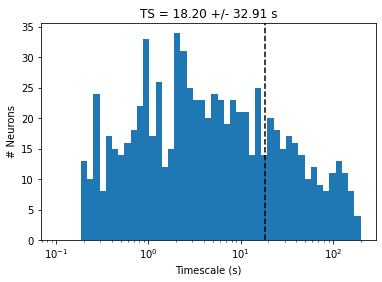

In [ ]:

tmp = np.sort(ts_out[~np.isnan(ts_out)])[::-1]
tmp = tmp[int(0.1 * tmp.size):int(0.9*tmp.size)]
plt.hist(tmp, bins=10 ** np.linspace(np.log10(0.1), np.log10(200), 50))
plt.xlabel('Timescale (s)')
plt.ylabel('# Neurons')
plt.gca().set_xscale("log")
plt.axvline(np.nanmean(tmp), ls='--', color='k')
plt.title(f"TS = {np.nanmean(tmp):.2f} +/- {np.nanstd(tmp):.2f} s")
plt.show()


#### Tuning curves

Text(0, 0.5, 'Firing Rate (z-score)')

<Figure size 432x288 with 0 Axes>

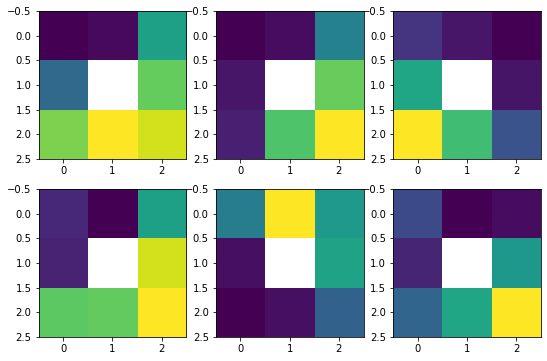

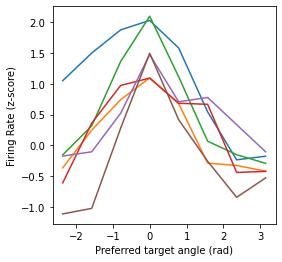

In [ ]:
# cue_locs = [[1, 0], [1, 1], [0, 1], [-1, 1], [-1, 0], [-1, -1], [0, -1], [1, -1], [0, 0]]
per_ix = 2
n_plot = 6
xy_ind = np.argsort(Rsq_xy[:, per_ix, 2])[::-1]
xy_ind = xy_ind[~np.isnan(Rsq_xy[xy_ind, per_ix, 2])][:n_plot]
tuning_curves = np.mean(z_rates_m_sem[0, :, per_ix], axis=-1)
tuning_curves = tuning_curves[xy_ind[:n_plot]]

imdat = np.nan * np.ones((n_plot, 3, 3))
px_ind = [3, 2, 1, 4, 7, 8, 9, 6]  # class_ix ==> indices of pixels in 3x3 image
plt.figure()
for px_ix, px in enumerate(px_ind):
    imdat[:, (px - 1) % 3, (px - 1) // 3] = tuning_curves[:, px_ix]
    
plt.figure(figsize=(9, 6))
for n_ix, im in enumerate(imdat):
    plt.subplot(2, 3, n_ix + 1)
    plt.imshow(im)

# Roll the curve so the max value is in pos 3
for n_ix, tune in enumerate(tuning_curves):
    tuning_curves[n_ix] = np.roll(tune, 3 - np.argmax(tune))
plt.figure(figsize=(4, 4))
plt.plot((np.arange(8) - 3) * 2*np.pi/8, tuning_curves.T)
plt.xlabel("Preferred target angle (rad)")
plt.ylabel("Firing Rate (z-score)")